In [80]:
import os
import tensorflow as tf

Retrive the data in the followin dir - http://mng.bz/0tIo

In [81]:
imdb_dir = './aclImdb'

In [82]:
train_dir = os.path.join(imdb_dir, 'train')

In [83]:
labels =[]
texts = []

In [84]:
for label_type in ['neg','pos']:
    dir_name = os.path.join(train_dir, label_type)
    for file in os.listdir(dir_name):
        if file[-4:] == '.txt':
            f = open(os.path.join(dir_name, file))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

KeyboardInterrupt: 

In [ ]:
len(texts)

In [18]:
len(labels)

25000

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
maxlen = 100
training_samples = 100
validation_samples = 100
max_words = 10000


In [24]:
tokenizer = Tokenizer(num_words = max_words)

In [25]:
tokenizer.fit_on_texts(texts)

In [26]:
sequences = tokenizer.texts_to_sequences(texts)

In [30]:
print('the sequence type is', type(sequences), ' and the seq len is', len(sequences))

the sequence type is <class 'list'>  and the seq len is 25000


In [27]:
word_index = tokenizer.word_index

In [33]:
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [34]:
data = pad_sequences(sequences, maxlen=maxlen)


In [35]:
print('the data type is', type(data), ' and the data len is', len(data))

the data type is <class 'numpy.ndarray'>  and the data len is 25000


In [37]:
import numpy as np
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [44]:
indices = np.arange(data.shape[0])
indices.shape

(25000,)

In [42]:
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [43]:
data.shape

(25000, 100)

In [39]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# Downloading the GloVe word embeddings
Go to https://nlp.stanford.edu/projects/glove, and download the precomputed embeddings from 2014 English Wikipedia. It’s an 822 MB zip file called glove.6B.zip, containing 100-dimensional embedding vectors for 400,000 words (or nonword tokens). Unzip it.

## Preprocessing the embeddings
Let’s parse the unzipped file (a .txt file) to build an index that maps words (as strings) to their vector representation (as number vectors).

In [46]:
glove_dir = './glove.6B'

In [49]:
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))

In [50]:
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [60]:
len(embeddings_index['king'])

100

Next, you’ll build an embedding matrix that you can load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in the reference word index (built during tokenization). Note that index 0 isn’t supposed to stand for any word or token—it’s a placeholder.



In [61]:
# this is the dimension of the embedding from glove.6B.100d.txt
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector



In [58]:
embedding_matrix.shape

(10000, 100)

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


The Embedding layer has a single weight matrix: a 2D float matrix where each entry i is the word vector meant to be associated with index i. Simple enough. Load the GloVe matrix you prepared into the Embedding layer, the first layer in the model.

In [64]:
# Since the co-relation between the words are already defined in geometric spac, we are re-using the same matrix weights, it need not be trainied again
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

Additionally, you’ll freeze the Embedding layer (set its trainable attribute to False), following the same rationale you’re already familiar with in the context of pretrained convnet features: when parts of a model are pretrained (like your Embedding layer) and parts are randomly initialized (like your classifier), the pretrained parts shouldn’t be updated during training, to avoid forgetting what they already know. The large gradient updates triggered by the randomly initialized layers would be disruptive to the already-learned features.

In [65]:
model.compile(optimizer='adam', metrics=['acc'], loss='binary_crossentropy')

In [66]:
history = model.fit(x_train, y_train, epochs=10, batch_size=20, validation_data=[x_val, y_val])

Epoch 1/10
5/5 [==============================] - 0s 34ms/step - loss: 1.0462 - acc: 0.4300 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
5/5 [==============================] - 0s 6ms/step - loss: 0.3511 - acc: 0.8200 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/10
5/5 [==============================] - 0s 8ms/step - loss: 0.1761 - acc: 0.9700 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0868 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/10
5/5 [==============================] - 0s 6ms/step - loss: 0.0349 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0188 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 7/10
5/5 [==============================] - 0s 7ms/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 8/10
5/5 [==============================]

In [67]:
model.save_weights('imdb_weights.h5')

In [71]:
import matplotlib.pyplot as plt

In [74]:
epocs = range(1, len(history.history['acc'])+1)

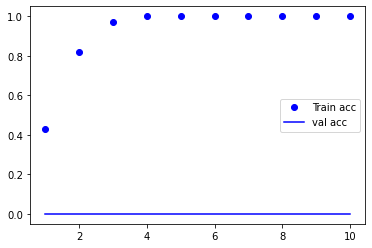

In [79]:
plt.plot(epocs, history.history['acc'], 'bo', label='Train acc')
plt.plot(epocs, history.history['val_acc'], 'b', label='val acc')
plt.legend()